<a href="https://colab.research.google.com/github/krheams60/Sales-predictions/blob/main/Project2_Part3_Ken_Rheams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, make_column_selector,
                             make_column_transformer)
from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay,
                             PrecisionRecallDisplay, RocCurveDisplay,
                             f1_score, accuracy_score, classification_report)
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn import set_config
set_config(display='diagram')

In [ ]:
# Load data
df = pd.read_csv('/content/archive.zip')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [ ]:
# Make copy 
eda_df = df.copy()

In [ ]:
# Check for missing or erroneous data, there are no missing values
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [ ]:
# Check for missing data and there is no missing data
eda_df.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [ ]:
# Check for duplicates
eda_df.duplicated().sum()

52

In [ ]:
# drop duplicates
eda_df.drop_duplicates(inplace=True)

In [ ]:
# duplicates dropped
eda_df.duplicated().sum()

0

In [ ]:
# Dropped columns that has no revelance to finding income range
df = df.drop(columns=['fnlwgt', 'educational-num', 'relationship', 'workclass'])
df.head()


,age,education,marital-status,occupation,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,11th,Never-married,Machine-op-inspct,Black,Male,0,0,40,United-States,<=50K
1,38,HS-grad,Married-civ-spouse,Farming-fishing,White,Male,0,0,50,United-States,<=50K
2,28,Assoc-acdm,Married-civ-spouse,Protective-serv,White,Male,0,0,40,United-States,>50K
3,44,Some-college,Married-civ-spouse,Machine-op-inspct,Black,Male,7688,0,40,United-States,>50K
4,18,Some-college,Never-married,?,White,Female,0,0,30,United-States,<=50K


In [ ]:
# value count of <=50K and >50K
df['income'].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

In [ ]:
# Replace income column with binary values
df['income'].replace({'<=50K':0, '>50K':1}, inplace=True)

 - This shows a weak correlation between income and the features
 

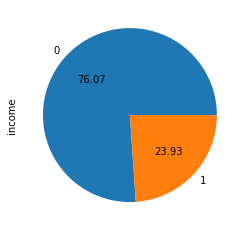

In [ ]:
# Pie chart for income values
df['income'].value_counts().plot(kind="pie", autopct="%.2f")
plt.show()

 - The pie chart shows that 76.07% have less or equal to $50,000 annual income
 

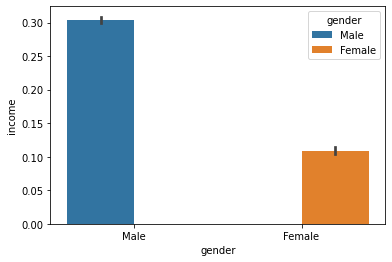

In [ ]:
sns.barplot(data=df, x="gender", y="income", hue="gender");

 - This graph shows the income level for Male and Female with Males having a
 - higher income than Females almost 3 times more
 

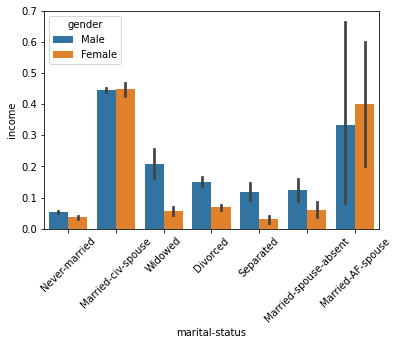

In [ ]:
sns.barplot(data=df, x="marital-status", y="income", hue="gender")
plt.xticks(rotation = 45);

 - The graph shows the marital status of males and females and having the males
 - overall with a higher income except for Married with spouse
 

In [ ]:
X = df.drop(columns='income')
y = df['income']

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
# Check the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   education       48842 non-null  object
 2   marital-status  48842 non-null  object
 3   occupation      48842 non-null  object
 4   race            48842 non-null  object
 5   gender          48842 non-null  object
 6   capital-gain    48842 non-null  int64 
 7   capital-loss    48842 non-null  int64 
 8   hours-per-week  48842 non-null  int64 
 9   native-country  48842 non-null  object
 10  income          48842 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 4.1+ MB


In [ ]:
df.dropna(subset=['education'], inplace=True)
df.isna().sum()

age               0
education         0
marital-status    0
occupation        0
race              0
gender            0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [ ]:
df.describe()

,age,capital-gain,capital-loss,hours-per-week,income
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1079.067626,87.502314,40.422382,0.239282
std,13.710510,7452.019058,403.004552,12.391444,0.426649
min,17.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,99999.000000,4356.000000,99.000000,1.000000


In [ ]:
scaler = StandardScaler()
mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
# Prepare separate processing pipelines for numeric and categorical data
num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)
# Create ColumnSelectors for the the numeric and categorical data
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
# Combine the Pipelines and ColumnSelectors into tuples for the ColumnTransformer
cat_tuple = (cat_pipe, cat_selector)
num_tuple = (num_pipe, num_selector)
# Create the preprocessing ColumnTransformer
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='drop')
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f756c2c6280>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f756c2c6df0>)])

In [ ]:
logreg = LogisticRegression()
logreg_pipe = make_pipeline(preprocessor, logreg)
logreg_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f756c2c6280>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f756c2c6df0>)])),
                ('logisticregression', LogisticRegression())])

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36631 entries, 27859 to 15795
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             36631 non-null  int64 
 1   education       36631 non-null  object
 2   marital-status  36631 non-null  object
 3   occupation      36631 non-null  object
 4   race            36631 non-null  object
 5   gender          36631 non-null  object
 6   capital-gain    36631 non-null  int64 
 7   capital-loss    36631 non-null  int64 
 8   hours-per-week  36631 non-null  int64 
 9   native-country  36631 non-null  object
dtypes: int64(4), object(6)
memory usage: 3.1+ MB


In [ ]:
logreg_pipe.fit(X_train, y_train)
training_predictions = logreg_pipe.predict(X_train)
test_predictions = logreg_pipe.predict(X_test)
training_predictions[:10]

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 0, 1, 1, 0, 1, 0, 1, 1, 0])

In [ ]:
dec_tree = DecisionTreeClassifier(random_state = 42)
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)
dec_tree_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f756c2c6280>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f756c2c6df0>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

In [ ]:
dec_tree_pipe.fit(X_train, y_train)

dec_tree_training_predictions = dec_tree_pipe.predict(X_train)
dec_tree_test_predictions = dec_tree_pipe.predict(X_test)
dec_tree_training_predictions[:10]

array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0])

In [ ]:
train_score = dec_tree_pipe.score(X_train, y_train)
test_score = dec_tree_pipe.score(X_test, y_test)
print(train_score)
print(test_score)

0.9623815893641997
0.825403324871018


In [ ]:
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [ ]:
dec_tree.get_depth()

47

In [ ]:
depths = list(range(2, 47))
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dec_tree_pipe.fit(X_train, y_train)
    train_score = dec_tree_pipe.score(X_train, y_train)
    test_score = dec_tree_pipe.score(X_test, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score

In [ ]:
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
2,0.825403,0.962382
25,0.825403,0.962382
27,0.825403,0.962382
28,0.825403,0.962382
29,0.825403,0.962382


In [ ]:
rf = RandomForestClassifier(random_state = 42)
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f756c2c6280>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f756c2c6df0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
rf_pipe.fit(X_train, y_train)

rf_training_predictions = rf_pipe.predict(X_train)
rf_test_predictions = rf_pipe.predict(X_test)
rf_training_predictions[:10]

array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0])

In [ ]:
train_score = rf_pipe.score(X_train, y_train)
test_score = rf_pipe.score(X_test, y_test)
print(train_score)
print(test_score)

0.9622450929540554
0.8475964294488576


In [ ]:
est_depths = [estimator.get_depth() for estimator in rf.estimators_]
max(est_depths)

73

In [ ]:
depths = range(1, max(est_depths))
scores = pd.DataFrame(index=depths, columns=['Test Score'])
for depth in depths:    
   rf = RandomForestClassifier(max_depth=depth)
   rf_pipe.fit(X_train, y_train)
   scores.loc[depth, 'Train Score'] = rf_pipe.score(X_train, y_train)
   scores.loc[depth, 'Test Score'] = rf_pipe.score(X_test, y_test)
   scores.head()

In [ ]:
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
1,0.847596,0.962245
2,0.847596,0.962245
53,0.847596,0.962245
52,0.847596,0.962245
51,0.847596,0.962245


In [ ]:
n_ests = [50, 100, 150, 200, 250]
scores2 = pd.DataFrame(index=n_ests, columns=['Test Score', 'Train Score'])
for n in n_ests:
   model = RandomForestClassifier(max_depth=52, n_estimators=n)
   rf_pipe.fit(X_train, y_train)
   scores2.loc[n, 'Train Score'] = rf_pipe.score(X_train, y_train)
   scores2.loc[n, 'Test Score'] = rf_pipe.score(X_test, y_test)
scores2.head()

,Test Score,Train Score
50,0.847596,0.962245
100,0.847596,0.962245
150,0.847596,0.962245
200,0.847596,0.962245
250,0.847596,0.962245


In [ ]:
pca = PCA(n_components = .95)

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
preprocessor = make_pipeline(StandardScaler(), PCA(n_components=2))